











### **Libraries**

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import scipy as sp
import pandas as pd
import matplotlib as mpl
import math as mt
import seaborn as sns

In [74]:
drive.mount('/drive', force_remount=True)

Mounted at /drive


### **Reading Data**

In [75]:
edd = pd.read_csv("/drive/My Drive/mcdata/eddington_data.txt", sep = " ", header=0).values.T

In [76]:
x = edd[0]
y = edd[1]
Ex = edd[2]
Ey = edd[3]
Dx_obs = edd[4]
Dy_obs = edd[5]

In [77]:
edd

array([[-1.261, -0.16 ,  0.334,  0.348,  0.587,  0.86 ,  1.079],
       [-0.16 , -1.107,  0.472,  0.36 ,  1.099,  1.321, -0.328],
       [-0.587, -0.557, -0.186, -0.222,  0.08 ,  0.158,  1.54 ],
       [ 0.036, -0.789,  1.336,  1.574,  0.726,  0.589, -0.156],
       [-1.416, -1.221, -1.054, -1.079, -1.012, -0.999, -0.733],
       [-1.324, -1.312, -0.944, -0.862, -0.932, -0.948, -1.019]])

### **Initial Parameters**

In [78]:
Ns = 10000                    #Total no. of samples
nburn = mt.floor(Ns/10)       #1st 10% of the samples is considered to be the burn-in phase
npar = 7                      #Total no. of parameters, alpha,a,b,c,d,e,f
nEdd = len(edd[1])            #size of data file
sig = 0.01*np.ones(7)         #Spread of the gaussian i.e decides the size of the proposal distribution


acc = np.zeros(2)          #vector to hold accepted samples and total samples
Dx = np.zeros(nEdd)           #vector to hold difference in Dx 
Dy = np.zeros(nEdd)           #vector to hold difference in Dy

theta = np.zeros([Ns,npar])      #holds the values of theta
theta[0] = np.random.uniform(size=7)     #initialising with a random starting point for the parameter theta
target = np.zeros(Ns)
target[0] = -1e100

accept = np.zeros([Ns,npar])      #stores accepted points
reject = np.zeros([Ns,npar])      #stores rejected points
accept[0]=theta[0]                 
reject[0]=theta[0]

In [79]:
theta[0]

array([0.45457526, 0.29545195, 0.59728311, 0.51873031, 0.78988871,
       0.83744204, 0.52449431])

### **MCMC sampling**

**Likelihood and other require functions**

In [80]:
def Dx_mod(theta,x,y,Ex):
  alp,a,b,c,d,e,f = theta
  Dx_mod = a*x+b*y+c+alp*Ex
  return Dx_mod

def Dy_mod(theta,x,y,Ey):
  alp,a,b,c,d,e,f = theta
  Dy_mod = d*x+e*y+f+alp*Ey
  return Dy_mod


#Likelihood distribution in log-scale
def likl(theta):
  alp,a,b,c,d,e,f = theta
  sigx,sigy = [0.05,0.05]
  if alp < 0:
    likl = -1.e100 
  else:  
    for j in range(nEdd):
        Dx[j] = Dx_obs[j] - Dx_mod(theta,x[j],y[j],Ex[j])
        Dy[j] = Dy_obs[j] - Dy_mod(theta,x[j],y[j],Ey[j])   
    likl = (-0.5*np.dot(Dx,Dx)/sigx**2) + (-0.5*np.dot(Dy,Dy)/sigy**2) 
  return likl 

**Metropolis Hastings algorithm**

In [81]:
def MH(initial,sigma):
  global accp
  global rej
  sigal, siga, sigb, sigc,sigd,sige,sigf = sigma
  alp0,a0,b0,c0,d0,e0,f0 = initial      
  alptrial = np.random.normal(alp0,sigal)              #drawing trial point considering a gaussian centered at previous point
  atrial = np.random.normal(a0,siga) 
  btrial = np.random.normal(b0,sigb)              
  ctrial = np.random.normal(c0,sigc) 
  dtrial = np.random.normal(d0,sigd)              
  etrial = np.random.normal(e0,sige) 
  ftrial = np.random.normal(f0,sigf) 
  theta_trial = alptrial,atrial,btrial,ctrial,dtrial,etrial,ftrial
  u = np.log(np.random.uniform())
  accept = likl(theta_trial)-likl(initial)      #minus in between since it is log-scaled
  if accept>0:
    theta_new = theta_trial
    a = 1                      #flags to 1 if the point is accepted
    accp = theta_new           #stores all the accepted points
  else:  
    if u<=accept:
        theta_new = theta_trial
        a = 1                   #flags to 1 if the point is accepted
        accp = theta_new  
    else:
        theta_new = initial
        a = 0                   #flags to 0 if the point is rejected
        rej = theta_trial       #stores all the rejected points
  return theta_new, a, accp, rej

In [82]:
#loop to run the MH sampling for Ns samples
for i in range(Ns-1):
  theta[i+1], a, accept[i+1], reject[i+1] = MH(theta[i],sig) 
  acc = acc + np.array((a,1))  

In [83]:
accept_avg = acc[0]/acc[1]    #average acceptance
accept_avg,acc

(0.5507550755075508, array([5507., 9999.]))

In [90]:
alpha_diff = np.mean(theta[:,0])
alpha = np.mean(theta[:,0]*19.8)        #19.8 is multiplied to bring it to arcsec units.
alph_std = np.std(theta[:,0])
print(alpha_diff,alpha,alph_std)

0.13177229537579765 2.6090914484407937 0.041543512373404284


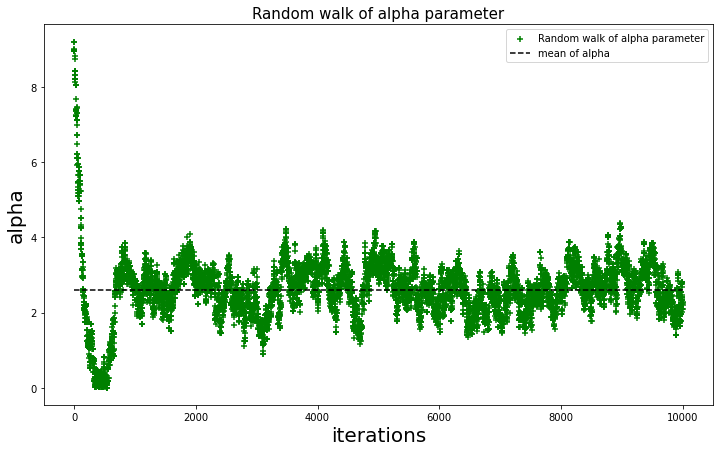

In [85]:
fig, axs = plt.subplots( figsize=(12,7))
axs.scatter(np.linspace(0,Ns,Ns),theta[:,0]*19.8,color='g',marker="+", label = 'Random walk of alpha parameter')
axs.set_xlabel('iterations', fontsize = 20)
axs.set_ylabel('alpha', fontsize = 20)
plt.hlines(alpha,0,Ns,linestyle="--", color='k',label = 'mean of alpha')
plt.title("Random walk of alpha parameter",fontsize=15)
plt.savefig("rand.jpg", format='jpg')
plt.legend()

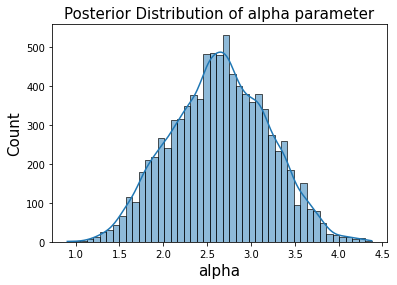

In [86]:
p = sns.histplot(data=theta,x =theta[nburn:,0]*19.8,kde=True)
plt.xlabel("alpha", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.title("Posterior Distribution of alpha parameter",fontsize=15)
plt.savefig("Dist.jpg", format='jpg')

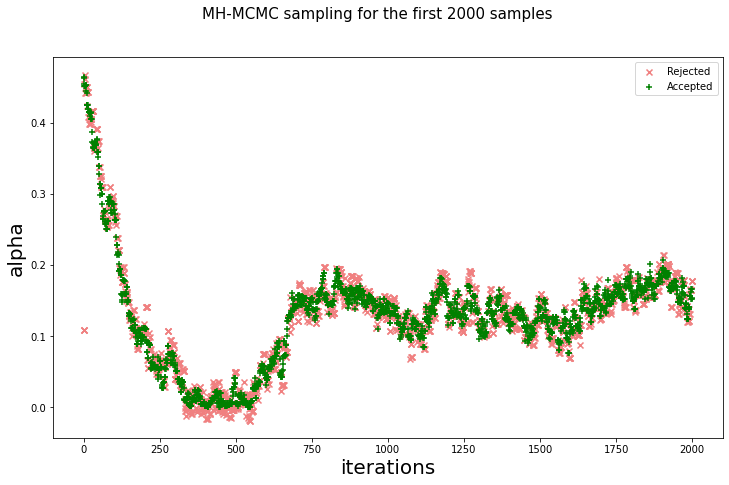

In [87]:
n = 0.2
Ns25 = int(n*Ns)
fig, axs = plt.subplots( figsize=(12,7))
axs.scatter(np.linspace(0,Ns25,Ns25),reject[0:Ns25:,0],color='lightcoral',marker="x", label = 'Rejected')
axs.scatter(np.linspace(0,Ns25,Ns25),accept[0:Ns25:,0],color='g', marker = "+", label = 'Accepted')
axs.set_xlabel('iterations', fontsize = 20)
axs.set_ylabel('alpha', fontsize = 20)
axs.legend()
# axs[0].set_ylim(0.4,0.7)
# axs[1].set_ylim(0.6,0.8)
fig.suptitle('MH-MCMC sampling for the first %d samples' %Ns25, fontsize = 15)
plt.savefig("acc&rej.jpg", format='jpg')